# Pet Finder Models

Training models predicting how long it will take for a pet to be adopted on the Pet Finder platform. Training data sourced from Kaggle competition.


## Set-up

### Import libraries

In [ ]:
!pip install -U sentence-transformers > /dev/null 2>&1

In [ ]:
from google.colab import drive
import pandas as pd
import gzip
import numpy as np
from zipfile import ZipFile
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import cv2
import random
import json
import shutil

from sklearn.model_selection import GroupKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import cohen_kappa_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

import re
import nltk
import string
from sentence_transformers import SentenceTransformer

import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import lightgbm as lgb
import joblib

### Set Pandas display options

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)
pd.set_option('max_seq_item', None)

### Check GPU

In [ ]:
# set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('running on device: {}'.format(device))

running on device: cuda


### Set up working directory

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/MSc Data Science/Research Project/data/petfinder-adoption-prediction')

In [ ]:
!ls

breed_labels.csv   lime_images		      test	       train_images
BreedLabels.csv    PetFinder-BreedLabels.csv  test_images      train_images.zip
color_labels.csv   PetFinder-ColorLabels.csv  test_metadata    train_metadata
ColorLabels.csv    PetFinder-StateLabels.csv  test_sentiment   train_sentiment
data_preprocessed  state_labels.csv	      train
lime_examples.csv  StateLabels.csv	      train_final.csv


### Set Random Seed

In [ ]:
# Random seed function 

seed=10

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministick = True
    torch.backends.cudnn.benchmark = False 
    
set_seed(seed)

## Data prep

### Load data

In [ ]:
# read in tabular data
data = pd.read_csv('train/train.csv')

data.head(1).T

,0
Type,2
Name,Nibble
Age,3
Breed1,299
Breed2,0
Gender,1
Color1,1
Color2,7
Color3,0
MaturitySize,1


In [ ]:
# check number of unique pets listed
data['PetID'].nunique()

14993

In [ ]:
# Correct data errors

# Replace Breed1 with Breed2 (where Breed 1 is N/A)
# data['Breed1'].replace(0, data['Breed2'], inplace=True)
def b1_b2_rep(b1,b2):
    if b1 == 0:
        return b2
    else:
        return b1

data['Breed1'] = data[['Breed1','Breed2']].apply(lambda x: b1_b2_rep(x[0],x[1]),axis=1)

# Replace Breed1 with 0
ids = ['1bc0f89d8', '15a206d0d', 'f8654865f', '36b20cfb5',
       '699a81c51', '85ec1aac0','6a72cfda7'] 
data.loc[data['PetID'].isin(ids), 'Breed1'] = 0

# Replace Breed2 with 0
ids = ['f8654865f', '699a81c51', '6a72cfda7']
data.loc[data['PetID'].isin(ids), 'Breed2'] = 0

# Change Type to 1
data.loc[data['PetID'] == '6c399cb06', 'Type'] = 1

In [ ]:
# read in ref data
breeds_df = pd.read_csv('breed_labels.csv')
colors_df = pd.read_csv('color_labels.csv')
states_df = pd.read_csv('state_labels.csv')

In [ ]:
# replace color codes with color descriptors
# data = pd.merge(data,colors_df, how='left', left_on='Color1',right_on='ColorID').drop(columns=['Color1','ColorID']).rename(columns={'ColorName':'Color1'})
# data = pd.merge(data,colors_df, how='left', left_on='Color2',right_on='ColorID').drop(columns=['Color2','ColorID']).rename(columns={'ColorName':'Color2'})
# data = pd.merge(data,colors_df, how='left', left_on='Color3',right_on='ColorID').drop(columns=['Color3','ColorID']).rename(columns={'ColorName':'Color3'})
# data.head(1).T

### Text features

In [ ]:
bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
bert.to(device)
next(bert.parameters()).is_cuda

True

In [ ]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [ ]:
%%time
sentences = data['Description'].astype(str).apply(text_preprocessing).tolist()
sentence_embeddings = bert.encode(sentences)

CPU times: user 26.9 s, sys: 7.36 s, total: 34.3 s
Wall time: 34.3 s


In [ ]:
sentence_embeddings.shape

(14993, 768)

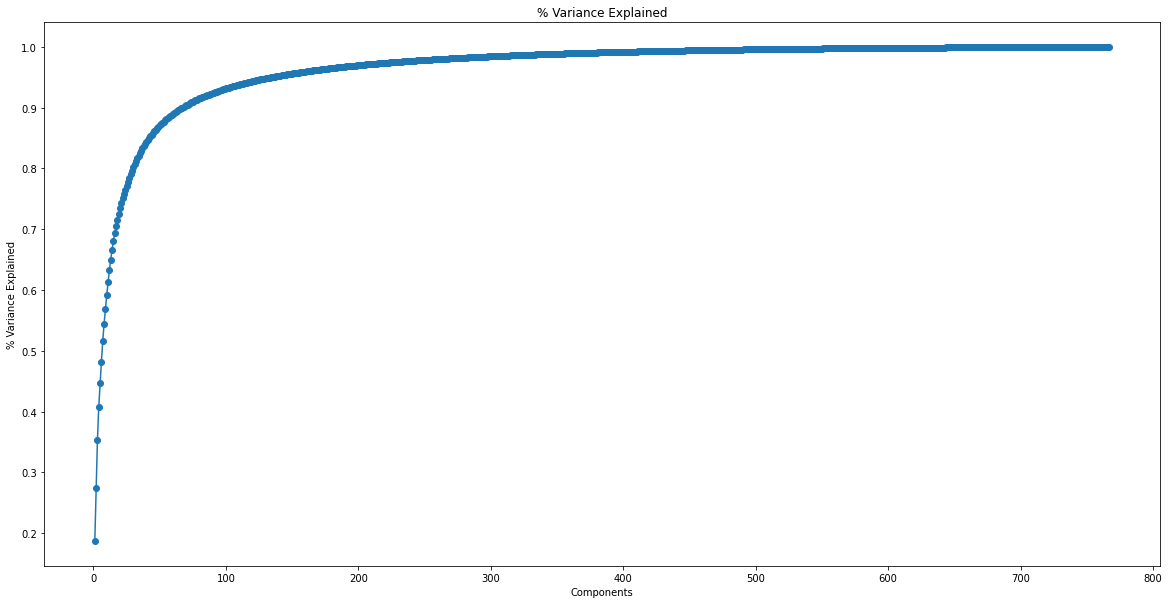

In [ ]:
# figure out how many SVD components to reduce embeddings to

# Initialise the SVD algorithm
svd = TruncatedSVD(n_components=sentence_embeddings.shape[1]-1, random_state=seed)

# Fit the SVD to your data 
scaler = StandardScaler()
df_svd = pd.DataFrame(svd.fit_transform(scaler.fit_transform(sentence_embeddings)))

# show explained variance plot
# ev = pca.explained_variance_
pct_ev = svd.explained_variance_.cumsum()/svd.explained_variance_.sum()
plt.figure(figsize=(20,10))
plt.scatter(range(1,df_svd.shape[1]+1),pct_ev)
plt.plot(range(1,df_svd.shape[1]+1),pct_ev)
plt.title('% Variance Explained')
plt.xlabel('Components')
plt.ylabel('% Variance Explained')
#plt.grid()
plt.show()

In [ ]:
# point of diminishing returns: 0.9 expl var.
# get num components explaining 0.9 var
comps = np.argmax(pct_ev>0.9) + 1
comps

67

In [ ]:
# perform SVD

# Initialise the SVD algorithm
svd = TruncatedSVD(n_components=comps, random_state=seed)

# Fit the SVD to your data 
se_scaler = StandardScaler()
text_feats = pd.DataFrame(svd.fit_transform(se_scaler.fit_transform(sentence_embeddings)))

# rename column headers
text_cols = [f'SE-{i+1}' for i in range(text_feats.shape[1])]
text_feats.columns = text_cols

text_feats.head()

,SE-1,SE-2,SE-3,SE-4,SE-5,SE-6,SE-7,SE-8,SE-9,SE-10,SE-11,SE-12,SE-13,SE-14,SE-15,SE-16,SE-17,SE-18,SE-19,SE-20,SE-21,SE-22,SE-23,SE-24,SE-25,SE-26,SE-27,SE-28,SE-29,SE-30,SE-31,SE-32,SE-33,SE-34,SE-35,SE-36,SE-37,SE-38,SE-39,SE-40,SE-41,SE-42,SE-43,SE-44,SE-45,SE-46,SE-47,SE-48,SE-49,SE-50,SE-51,SE-52,SE-53,SE-54,SE-55,SE-56,SE-57,SE-58,SE-59,SE-60,SE-61,SE-62,SE-63,SE-64,SE-65,SE-66,SE-67
0,-12.393422,-6.408876,4.226560,4.512883,3.306035,4.279845,-2.215994,4.742575,-1.694335,3.066341,4.136243,-0.231358,-1.069092,1.006579,1.232957,-2.262699,-0.752501,0.930143,-3.716865,0.919330,0.091283,6.740059,-0.008617,-0.362843,1.469222,-1.200767,-0.900734,0.049866,-1.510801,-3.209438,0.646002,-0.153043,0.365061,-1.796061,3.357550,-0.481051,1.562112,-1.479359,0.902506,-0.691815,0.482919,-1.595094,-0.572366,1.945500,0.172906,1.231582,0.501752,-1.021358,1.023743,0.452597,0.923546,-0.103789,-1.092911,-0.522009,-0.202785,1.047780,1.157202,-0.282549,-1.034336,-0.858075,-1.025945,-0.568321,-0.403821,1.138765,0.716594,0.561175,0.003795
1,0.380169,-11.606069,-5.605418,5.712368,9.232963,4.062428,-8.886344,-8.998353,6.472664,10.433329,0.169532,-9.162574,4.202955,1.894176,5.764140,-0.958674,1.765353,-1.654784,1.172765,3.085515,1.149951,0.034496,-4.852117,0.283912,-5.752265,0.968014,0.198266,2.499027,-2.589029,1.862745,-4.017632,0.488654,0.733731,2.087258,2.689998,2.787896,2.224927,-1.684641,2.999521,-2.320117,0.046236,-0.622545,-3.074526,0.657417,-0.071680,-1.523867,-3.634485,0.634358,1.152141,0.992021,0.253287,-1.128933,-0.774800,-0.604302,-1.929918,0.739948,-2.717095,-1.814374,1.675192,0.098595,0.930450,0.804492,-0.396921,-0.498149,0.455695,0.028993,-2.219803
2,-10.519945,-2.985444,-2.871733,-0.050807,2.195919,-1.381407,5.505780,-6.409534,1.536174,1.318434,2.061656,2.748373,1.941793,-3.871794,-0.361016,-3.934612,-2.282228,-0.217365,1.235182,1.227706,-0.914815,-1.878702,0.924340,2.736413,-0.781137,-1.457618,-0.925857,-1.177958,3.047004,3.994022,0.393702,1.381779,-1.248500,-2.128027,-0.786764,-0.531169,2.472485,1.522147,-1.580299,0.805021,0.147945,0.666470,0.720646,0.376642,-1.622525,-0.703534,-0.758942,0.719339,-0.144046,-2.298834,0.092175,-0.597548,-0.512087,1.150723,-0.592324,1.198506,-0.220414,0.351650,1.368720,0.465133,0.770988,-1.152852,-0.473830,0.625785,-0.491978,-1.367283,0.713013
3,3.225149,8.563666,-7.960811,3.191395,-6.114994,-6.699689,-5.800200,-4.905365,1.992607,-1.795625,3.977045,10.397885,2.618696,3.891024,4.856381,7.128413,3.831671,-4.491846,7.194201,-0.787184,-2.931347,0.319893,2.527065,-2.494722,-4.564695,1.610018,-4.806290,-0.463972,1.914929,-1.355631,-1.777230,-1.979364,-1.824311,1.921870,0.761843,-1.004897,1.787878,2.434838,2.058488,-0.559545,2.055497,-0.444799,2.015642,-1.741575,0.780357,0.976394,1.837804,0.153332,-1.189848,-0.289884,1.725010,-0.188725,-1.142301,-0.272610,0.512908,0.235461,0.494114,1.266973,-1.774227,-1.203188,0.784621,-1.772079,1.405561,-1.205403,1.994869,-0.201369,-1.821864
4,-3.226658,12.474442,-8.933537,-3.931106,-4.139126,-1.591606,-1.501523,11.654406,1.521008,1.732243,0.425815,-3.691110,0.020072,-2.665285,-1.519622,-0.343549,0.693139,-1.317245,-0.267609,-0.466646,-1.120138,-0.664012,-1.142462,-0.900215,-1.799854,-1.154144,-0.523928,2.137026,-2.166421,-1.520453,0.233381,0.960517,-0.165090,0.412742,-0.921651,-2.595826,0.989769,0.566419,-0.223691,0.691525,1.534371,-0.453567,-0.988476,-0.533877,-0.774139,1.622667,1.129124,0.551358,-0.858327,0.560845,-0.378242,0.504847,-0.466065,0.904383,-0.897636,-0.169743,-0.538658,0.386831,0.415327,-0.494779,-0.610101,-0.765154,-0.601116,-1.186203,-0.323758,-0.447105,0.376015


### Image features

In [ ]:
# load preprocessed image embeddings
img_output = pd.read_csv('data_preprocessed/img_output.csv')
print(img_output.shape)

(14652, 257)


In [ ]:
# merge image embeddings back into main data
img_feats = pd.merge(data,img_output,how='left',on='PetID').iloc[:,24:]

img_feats.shape

(14993, 256)

In [ ]:
# fill in blanks with black image
mode = 'RGB' 
size = (224, 224)
color = (0, 0, 0)
img = Image.new(mode, size, color)

# load pre-trained resnet50 model
densenet = models.densenet121(pretrained=True)
# remove output layer to extract embeddings
densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
densenet.eval()

# define transform to convert images to tensor (ready for resnet50)
transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ])

# extract image embedding
avgpool1d = torch.nn.AvgPool1d(4)
out = densenet(torch.stack([transform(img)]))
out = avgpool1d(out.mean([2,3]).unsqueeze(0)).squeeze(0).detach().numpy()

# fill in blanks
img_feats.loc[(img_feats['0'].isna()),:] = out
# change column headers
img_cols = [f'IE-{i+1}' for i in range(img_feats.shape[1])]
img_feats.columns = img_cols

img_feats.head()

,IE-1,IE-2,IE-3,IE-4,IE-5,IE-6,IE-7,IE-8,IE-9,IE-10,IE-11,IE-12,IE-13,IE-14,IE-15,IE-16,IE-17,IE-18,IE-19,IE-20,IE-21,IE-22,IE-23,IE-24,IE-25,IE-26,IE-27,IE-28,IE-29,IE-30,IE-31,IE-32,IE-33,IE-34,IE-35,IE-36,IE-37,IE-38,IE-39,IE-40,IE-41,IE-42,IE-43,IE-44,IE-45,IE-46,IE-47,IE-48,IE-49,IE-50,IE-51,IE-52,IE-53,IE-54,IE-55,IE-56,IE-57,IE-58,IE-59,IE-60,IE-61,IE-62,IE-63,IE-64,IE-65,IE-66,IE-67,IE-68,IE-69,IE-70,IE-71,IE-72,IE-73,IE-74,IE-75,IE-76,IE-77,IE-78,IE-79,IE-80,IE-81,IE-82,IE-83,IE-84,IE-85,IE-86,IE-87,IE-88,IE-89,IE-90,IE-91,IE-92,IE-93,IE-94,IE-95,IE-96,IE-97,IE-98,IE-99,IE-100,IE-101,IE-102,IE-103,IE-104,IE-105,IE-106,IE-107,IE-108,IE-109,IE-110,IE-111,IE-112,IE-113,IE-114,IE-115,IE-116,IE-117,IE-118,IE-119,IE-120,IE-121,IE-122,IE-123,IE-124,IE-125,IE-126,IE-127,IE-128,IE-129,IE-130,IE-131,IE-132,IE-133,IE-134,IE-135,IE-136,IE-137,IE-138,IE-139,IE-140,IE-141,IE-142,IE-143,IE-144,IE-145,IE-146,IE-147,IE-148,IE-149,IE-150,IE-151,IE-152,IE-153,IE-154,IE-155,IE-156,IE-157,IE-158,IE-159,IE-160,IE-161,IE-162,IE-163,IE-164,IE-165,IE-166,IE-167,IE-168,IE-169,IE-170,IE-171,IE-172,IE-173,IE-174,IE-175,IE-176,IE-177,IE-178,IE-179,IE-180,IE-181,IE-182,IE-183,IE-184,IE-185,IE-186,IE-187,IE-188,IE-189,IE-190,IE-191,IE-192,IE-193,IE-194,IE-195,IE-196,IE-197,IE-198,IE-199,IE-200,IE-201,IE-202,IE-203,IE-204,IE-205,IE-206,IE-207,IE-208,IE-209,IE-210,IE-211,IE-212,IE-213,IE-214,IE-215,IE-216,IE-217,IE-218,IE-219,IE-220,IE-221,IE-222,IE-223,IE-224,IE-225,IE-226,IE-227,IE-228,IE-229,IE-230,IE-231,IE-232,IE-233,IE-234,IE-235,IE-236,IE-237,IE-238,IE-239,IE-240,IE-241,IE-242,IE-243,IE-244,IE-245,IE-246,IE-247,IE-248,IE-249,IE-250,IE-251,IE-252,IE-253,IE-254,IE-255,IE-256
0,-0.000282,0.180222,-0.015848,0.005220,-0.041011,0.001255,-0.001020,0.001874,-0.116453,0.044416,0.084228,-0.000395,-0.012480,-0.002751,0.016292,0.019715,0.003395,0.016114,-0.000080,0.000066,-0.010246,0.028157,0.051440,0.001501,0.191349,0.011841,0.141587,0.002880,0.002256,-0.126352,0.033012,-0.118615,-0.007962,0.026494,0.178306,0.311132,-0.015867,0.004895,0.184922,0.000381,-0.033908,0.007641,-0.091082,-0.000740,0.009722,-0.014461,0.001364,0.008547,0.005849,0.150490,0.012481,0.033279,-0.168767,0.027202,0.000013,0.002436,-0.001411,-0.167451,-0.152851,-0.000483,0.021171,0.005120,-0.000639,0.005937,0.109330,-0.118745,-0.000061,-0.064155,0.000178,0.036625,0.010374,-0.066347,0.000388,-0.284557,0.000280,0.068641,0.029451,-0.019990,0.004356,0.005132,0.001591,-0.002172,-0.014300,-0.091890,0.001486,0.000095,0.035527,-0.032678,0.027435,-0.000786,0.004501,0.007962,0.001302,-0.001709,0.128056,0.003772,-0.048647,-0.002496,-0.000114,0.004503,0.003599,0.000772,-0.080076,0.000219,-0.000767,0.006397,0.099371,0.000010,-0.007156,0.210505,0.004005,0.055262,0.132353,0.000626,0.005591,-0.071598,0.022659,0.000681,0.154499,0.001842,-0.006645,0.003937,-0.000315,-0.000411,0.009943,0.001325,0.906704,0.048639,0.151694,0.717297,0.536499,-0.039471,0.379751,0.437628,0.228474,0.510666,1.181260,0.277529,0.964366,0.831934,1.519186,0.163162,0.614344,-0.575568,0.804568,-0.021660,-0.445438,0.265932,0.458095,0.941836,0.316146,0.782346,0.479257,0.305769,0.720142,0.264471,1.634072,0.246587,-0.022127,0.247655,0.020679,-0.198479,0.252076,0.305870,1.332723,-0.138098,0.049936,1.309917,0.849455,1.468594,-0.025761,0.429206,0.324164,0.825232,0.324214,0.644775,0.011862,0.045952,1.572766,0.920222,0.314537,1.309340,0.212140,1.314868,0.264082,0.203705,-0.271512,1.348157,2.228131,0.799279,-0.057694,0.017617,0.161597,0.591071,0.096180,1.379328,-0.075822,0.031912,0.066837,0.209117,0.047972,1.121727,0.124186,0.828980,0.351317,0.419894,0.292971,1.886344,0.918442,0.233622,0.529139,0.288286,0.917519,0.199676,0.103970,-0.000580,0.769587,0.280414,0.514806,0.323215,0.447154,1.213681,0.910516,-0.054043,0.525306,0.030041,0.023987,0.344985,0.049838,-0.045955,0.787622,0.522992,2.114423,0.557647,0.325087,0.634370,0.705139,0.605666,0.392257,-0.436785,1.697504,1.542968,-0.571505,0.625254,1.131157,0.412446,0.340013,0.209192,0.272234,1.096742,-

### Numeric features

In [ ]:
numeric_cols = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

numeric_feats = data[numeric_cols].copy()

numeric_feats.head()

,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt
0,3,1,1,1,1,100,0,1.0
1,1,2,2,1,1,0,0,2.0
2,1,2,2,1,1,0,0,7.0
3,4,2,1,1,1,150,0,8.0
4,1,2,1,1,1,0,0,3.0


### Categorical features

In [ ]:
# create name missing flag
data['Name Missing'] = data['Name'].isna()*1

In [ ]:
cat_cols = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'Vaccinated', 'Dewormed', 'Sterilized',
            'Name Missing', 'Breed1', 'Breed2', 'State']

cat_feats = data[cat_cols].copy()

### Merge features together

In [ ]:
X = pd.concat([data[['PetID']], text_feats, img_feats, numeric_feats, cat_feats], axis=1).set_index('PetID')
print(X.shape)
X.head()

(14993, 343)


,SE-1,SE-2,SE-3,SE-4,SE-5,SE-6,SE-7,SE-8,SE-9,SE-10,SE-11,SE-12,SE-13,SE-14,SE-15,SE-16,SE-17,SE-18,SE-19,SE-20,SE-21,SE-22,SE-23,SE-24,SE-25,SE-26,SE-27,SE-28,SE-29,SE-30,SE-31,SE-32,SE-33,SE-34,SE-35,SE-36,SE-37,SE-38,SE-39,SE-40,SE-41,SE-42,SE-43,SE-44,SE-45,SE-46,SE-47,SE-48,SE-49,SE-50,SE-51,SE-52,SE-53,SE-54,SE-55,SE-56,SE-57,SE-58,SE-59,SE-60,SE-61,SE-62,SE-63,SE-64,SE-65,SE-66,SE-67,IE-1,IE-2,IE-3,IE-4,IE-5,IE-6,IE-7,IE-8,IE-9,IE-10,IE-11,IE-12,IE-13,IE-14,IE-15,IE-16,IE-17,IE-18,IE-19,IE-20,IE-21,IE-22,IE-23,IE-24,IE-25,IE-26,IE-27,IE-28,IE-29,IE-30,IE-31,IE-32,IE-33,IE-34,IE-35,IE-36,IE-37,IE-38,IE-39,IE-40,IE-41,IE-42,IE-43,IE-44,IE-45,IE-46,IE-47,IE-48,IE-49,IE-50,IE-51,IE-52,IE-53,IE-54,IE-55,IE-56,IE-57,IE-58,IE-59,IE-60,IE-61,IE-62,IE-63,IE-64,IE-65,IE-66,IE-67,IE-68,IE-69,IE-70,IE-71,IE-72,IE-73,IE-74,IE-75,IE-76,IE-77,IE-78,IE-79,IE-80,IE-81,IE-82,IE-83,IE-84,IE-85,IE-86,IE-87,IE-88,IE-89,IE-90,IE-91,IE-92,IE-93,IE-94,IE-95,IE-96,IE-97,IE-98,IE-99,IE-100,IE-101,IE-102,IE-103,IE-104,IE-105,IE-106,IE-107,IE-108,IE-109,IE-110,IE-111,IE-112,IE-113,IE-114,IE-115,IE-116,IE-117,IE-118,IE-119,IE-120,IE-121,IE-122,IE-123,IE-124,IE-125,IE-126,IE-127,IE-128,IE-129,IE-130,IE-131,IE-132,IE-133,IE-134,IE-135,IE-136,IE-137,IE-138,IE-139,IE-140,IE-141,IE-142,IE-143,IE-144,IE-145,IE-146,IE-147,IE-148,IE-149,IE-150,IE-151,IE-152,IE-153,IE-154,IE-155,IE-156,IE-157,IE-158,IE-159,IE-160,IE-161,IE-162,IE-163,IE-164,IE-165,IE-166,IE-167,IE-168,IE-169,IE-170,IE-171,IE-172,IE-173,IE-174,IE-175,IE-176,IE-177,IE-178,IE-179,IE-180,IE-181,IE-182,IE-183,IE-184,IE-185,IE-186,IE-187,IE-188,IE-189,IE-190,IE-191,IE-192,IE-193,IE-194,IE-195,IE-196,IE-197,IE-198,IE-199,IE-200,IE-201,IE-202,IE-203,IE-204,IE-205,IE-206,IE-207,IE-208,IE-209,IE-210,IE-211,IE-212,IE-213,IE-214,IE-215,IE-216,IE-217,IE-218,IE-219,IE-220,IE-221,IE-222,IE-223,IE-224,IE-225,IE-226,IE-227,IE-228,IE-229,IE-230,IE-231,IE-232,IE-233,IE-234,IE-235,IE-236,IE-237,IE-238,IE-239,IE-240,IE-241,IE-242,IE-243,IE-244,IE-245,IE-246,IE-247,IE-248,IE-249,IE-250,IE-251,IE-252,IE-253,IE-254,IE-255,IE-256,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,Type,Gender,Color1,Color2,Color3,Vaccinated,Dewormed,Sterilized,Name Missing,Breed1,Breed2,State
PetID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86e1089a3,-12.393422,-6.408876,4.226560,4.512883,3.306035,4.279845,-2.215994,4.742575,-1.694335,3.066341,4.136243,-0.231358,-1.069092,1.006579,1.232957,-2.262699,-0.752501,0.930143,-3.716865,0.919330,0.091283,6.740059,-0.008617,-0.362843,1.469222,-1.200767,-0.900734,0.049866,-1.510801,-3.209438,0.646002,-0.153043,0.365061,-1.796061,3.357550,-0.481051,1.562112,-1.479359,0.902506,-0.691815,0.482919,-1.595094,-0.572366,1.945500,0.172906,1.231582,0.501752,-1.021358,1.023743,0.452597,0.923546,-0.103789,-1.092911,-0.522009,-0.202785,1.047780,1.157202,-0.282549,-1.034336,-0.858075,-1.025945,-0.568321,-0.403821,1.138765,0.716594,0.561175,0.003795,-0.000282,0.180222,-0.015848,0.005220,-0.041011,0.001255,-0.001020,0.001874,-0.116453,0.044416,0.084228,-0.000395,-0.012480,-0.002751,0.016292,0.019715,0.003395,0.016114,-0.000080,0.000066,-0.010246,0.028157,0.051440,0.001501,0.191349,0.011841,0.141587,0.002880,0.002256,-0.126352,0.033012,-0.118615,-0.007962,0.026494,0.178306,0.311132,-0.015867,0.004895,0.184922,0.000381,-0.033908,0.007641,-0.091082,-0.000740,0.009722,-0.014461,0.001364,0.008547,0.005849,0.150490,0.012481,0.033279,-0.168767,0.027202,0.000013,0.002436,-0.001411,-0.167451,-0.152851,-0.000483,0.021171,0.005120,-0.000639,0.005937,0.109330,-0.118745,-0.000061,-0.064155,0.000178,0.036625,0.010374,-0.066347,0.000388,-0.284557,0.000280,0.068641,0.029451,-0.019990,0.004356,0.005132,0.001591,-0.00

### Amend class labels

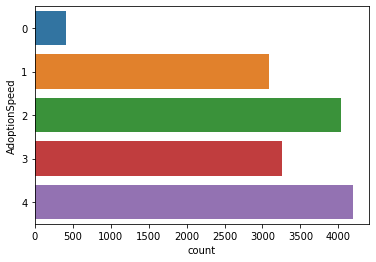

In [ ]:
ax = sns.countplot(y='AdoptionSpeed', data=data)

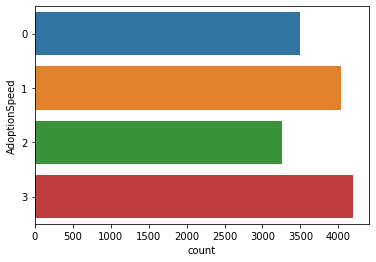

In [ ]:
# create labels df
y = data[['PetID', 'AdoptionSpeed']].set_index('PetID')

def relabel(label,old_value,new_value):
    if label == old_value:
        return new_value
    else:
        return label

# merge 0 and 1 labels together
y['AdoptionSpeed'] = y['AdoptionSpeed'].apply(lambda x: relabel(x,0,1)) - 1

ax = sns.countplot(y='AdoptionSpeed', data=y)

### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state = seed)
print('train size:', X_train.shape[0])
# print('val size:', X_val.shape[0])
print('test size:', X_test.shape[0])

train size: 11994
test size: 2999


In [ ]:
# save train data (needed for lime tabular explainer)
df = pd.concat([X_train,y_train],axis=1)
df = pd.merge(data.drop(columns=['Name Missing','AdoptionSpeed']),
              df.reset_index()[['PetID','AdoptionSpeed']],on='PetID')
df.to_csv('train_final.csv',index=False)
df.shape

(11994, 24)

### Balance classes

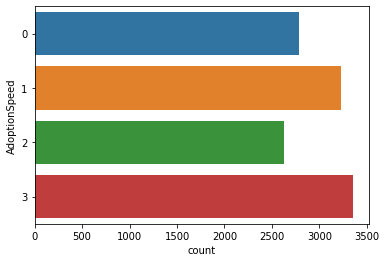

In [ ]:
# show classes in train set
ax = sns.countplot(y='AdoptionSpeed', data=y_train)

In [ ]:
y_0 = y_train[y_train['AdoptionSpeed']==0].copy()
y_1 = y_train[y_train['AdoptionSpeed']==1].copy()
y_2 = y_train[y_train['AdoptionSpeed']==2].copy()
y_3 = y_train[y_train['AdoptionSpeed']==3].copy()

lc_0 = y_0.shape[0]
lc_1 = y_1.shape[0]
lc_2 = y_2.shape[0]
lc_3 = y_3.shape[0]

# up-sample 0 labels
y_0 = pd.concat([y_0,resample(y_0, replace=True, n_samples=lc_3-lc_0, random_state=seed)])
# up-sample 1 labels
y_1 = pd.concat([y_1,resample(y_1, replace=True, n_samples=lc_3-lc_1, random_state=seed)])
# up-sample 2 labels
y_2 = pd.concat([y_2,resample(y_2, replace=True, n_samples=lc_3-lc_2, random_state=seed)])

# concatenate all labels together
y_train = pd.concat([y_0,y_1,y_2,y_3],axis=0)

y_train.shape

(13432, 1)

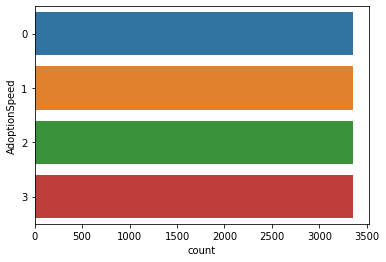

In [ ]:
ax = sns.countplot(y='AdoptionSpeed', data=y_train)

In [ ]:
# amend features to reflect resampled labels
X_train = pd.merge(X_train,y_train,left_index=True,right_index=True)

# shuffle rows
X_train = X_train.sample(frac=1, random_state=seed)

# recreate labels df (to ensure lines up with feats)
y_train = X_train[['AdoptionSpeed']]
X_train = X_train.drop(columns=['AdoptionSpeed'])

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)

X_train shape: (13432, 343)
y_train shape: (13432, 1)


### Rescale data

In [ ]:
%%capture
# Text feats
text_scaler = StandardScaler()
X_train[text_cols] = text_scaler.fit_transform(X_train[text_cols])
X_test[text_cols] = text_scaler.transform(X_test[text_cols])

# Image feats
img_scaler = StandardScaler()
X_train[img_cols] = img_scaler.fit_transform(X_train[img_cols])
X_test[img_cols] = img_scaler.transform(X_test[img_cols])

# Numeric feats
num_scaler = StandardScaler()
X_train[numeric_cols] = num_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_scaler.transform(X_test[numeric_cols])

## Modelling

### Define error metrics

In [ ]:
# Regression objective
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Competition metric
def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

### Threshold Optimisation

In [ ]:
from functools import partial
import numpy as np
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            else:
                X_p[i] = 3

        ll = qwk(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            else:
                X_p[i] = 3
                
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
# function to bucket raw real-valued predictions into final predicted labels
def round_preds(y_pred, thresholds):
    rates = np.zeros(y_pred.size, dtype=int)
    for i in range(len(thresholds)):
        rates[y_pred > thresholds[i]] = i + 1
    return rates

### LightGBM

#### Training

In [ ]:
%%time

# LGB datasets
split = round(len(X_train)*0.95)
X_tr, y_tr, X_val, y_val = X_train[:split], y_train[:split], X_train[split:], y_train[split:]
d_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols)
d_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)
val_sets = [d_train, d_val]

# set model parameters
params = {'objective': 'mse',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 10,
          'max_depth': 5,
          'min_data_in_leaf': 60,
          'learning_rate': 0.01,
          'bagging_fraction': 0.5,
          'bagging_freq': 1,
          'feature_fraction': 0.3,
          'feature_fraction_seed': 73,
          'lambda_l1': 0,
          'lambda_l2': 0.3,
          'verbosity': -1,
          'seed': seed}

EARLY_STOPPING_ROUNDS = 500
VERBOSE_EVAL = 100
NUM_BOOST_ROUND = 4500

# Training
model = lgb.train(params,
                    train_set=d_train,
                    num_boost_round=NUM_BOOST_ROUND,
                    valid_sets=val_sets,
                    verbose_eval=VERBOSE_EVAL,
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    categorical_feature=cat_cols)

# Predictions
preds_tr = model.predict(X_tr)
preds_val = model.predict(X_val)

# Rounding
optR = OptimizedRounder()
optR.fit(preds_tr, y_tr)
thresholds = optR.coefficients()
preds_val_rounded = round_preds(preds_val, thresholds)

# Evaluation
qwk_val = qwk(y_val, preds_val_rounded)
acc_val = accuracy_score(y_val, preds_val_rounded)
rmse_val = rmse(y_val, preds_val)
print('QWK: {}, RMSE: {}, ACC: {}\n'.format(qwk_val, rmse_val, acc_val))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.05706	valid_1's rmse: 1.08977
[200]	training's rmse: 1.02348	valid_1's rmse: 1.06336
[300]	training's rmse: 1.00035	valid_1's rmse: 1.04755
[400]	training's rmse: 0.982474	valid_1's rmse: 1.03689
[500]	training's rmse: 0.968067	valid_1's rmse: 1.02955
[600]	training's rmse: 0.95516	valid_1's rmse: 1.02379
[700]	training's rmse: 0.943484	valid_1's rmse: 1.01928
[800]	training's rmse: 0.932691	valid_1's rmse: 1.01476
[900]	training's rmse: 0.922637	valid_1's rmse: 1.01217
[1000]	training's rmse: 0.913281	valid_1's rmse: 1.00947
[1100]	training's rmse: 0.904243	valid_1's rmse: 1.00695
[1200]	training's rmse: 0.895399	valid_1's rmse: 1.00441
[1300]	training's rmse: 0.886975	valid_1's rmse: 1.00209
[1400]	training's rmse: 0.87857	valid_1's rmse: 1.00071
[1500]	training's rmse: 0.87031	valid_1's rmse: 0.998912
[1600]	training's rmse: 0.86262	valid_1's rmse: 0.997486
[1700]	training's rmse: 0.85504	valid_1

#### Testing

In [ ]:
# Get optimal thresholds from train data
preds_train = model.predict(X_tr)
optR = OptimizedRounder()
optR.fit(preds_train, y_tr)
thresholds = optR.coefficients()

# Predictions
preds_test = model.predict(X_test)

# Rounding
preds_test_rounded = round_preds(preds_test, thresholds)

# Evaluation
qwk_test = qwk(y_test, preds_test_rounded)
rmse_test = rmse(y_test, preds_test)
acc_test = accuracy_score(y_test, preds_test_rounded)

print('QWK: {}'.format(qwk_test))
print('RMSE: {}'.format(rmse_test))
print('ACC: {}'.format(acc_test))


QWK: 0.43648140437904204
RMSE: 1.0077748199062206
ACC: 0.377459153051017


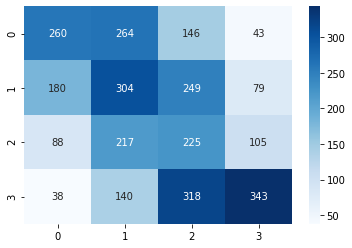

In [ ]:
sns.heatmap(confusion_matrix(y_test, preds_test_rounded),cmap='Blues',annot=True, fmt='g')

#### Deployment

Deploy on the examples left out of training, to see how the model performs

In [ ]:
# pick pet at random, with specific adoption speed
ADOPTION_SPEED = 3
petid = X_test.reset_index().loc[(np.array(y_test==ADOPTION_SPEED)),['PetID']].sample(n=1).values.item()
petid

'21c8d5f0e'

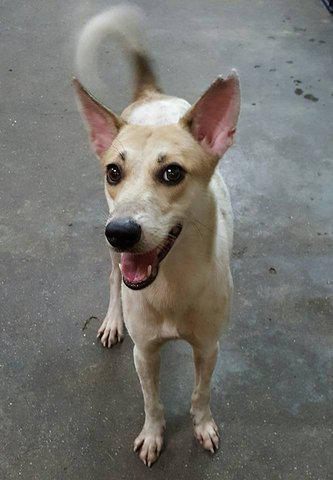

In [ ]:
# show main image
Image.open(f'train_images/{petid}-1.jpg')

In [ ]:
# show other data relating to pet
data[data['PetID']==petid].drop(columns=['AdoptionSpeed']).T

,6673
Type,1
Name,Remi
Age,4
Breed1,307
Breed2,0
Gender,2
Color1,1
Color2,2
Color3,7
MaturitySize,2


In [ ]:
# Predictions
pred = model.predict(X_test[X_test.index==petid])

# Rounding
pred_rounded = round_preds(pred, thresholds)

print('pred:',pred[0])
print('pred rounded:',pred_rounded.item())

pred: 2.358893732813245
pred rounded: 3


In [ ]:
# # create pipeline to run model on new unlabelled examples 
# def batch_predict(pet_ids, data):

#     # convert pet ids to list
#     if not isinstance(pet_ids,list):
#         pet_ids = [pet_ids]

#     # dedupe pet ids
#     pet_ids = list(set(pet_ids))

#     # get images
#     tf_resize = transforms.Resize((224,224))
#     tf_totensor = transforms.Compose([
#                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#                                     ]) 
#     ips = sorted(glob.glob('train_images/*-1.jpg') + glob.glob('test_images/*-1.jpg'))
#     ips = [ip for ip in ips if ip.split('/')[1].split('-')[0] in pet_ids]
#     # images = [np.array(tf_resize(Image.open(ip))) for ip in ips]
    
#     # filter pet_ids for ones with images only
#     pet_ids = [ip.split('/')[1].split('-')[0] for ip in ips]

#     # create name missing feature
#     data['Name Missing'] = data['Name'].isna()*1
#     # get relevant rows relating to petid
#     rows = data[data['PetID'].isin(pet_ids)].sort_values('PetID')
#     # get pet id's from rows to ensure they align
#     pet_ids = rows['PetID'].tolist()

#     # text feature extraction
#     text_data = rows['Description'].tolist()
#     if not isinstance(text_data,list):
#         text_data = [text_data]
#     sentence_embeddings = bert.encode([text_preprocessing(str(text)) for text in text_data])
#     text_feats = svd.transform(scaler.transform(sentence_embeddings))
#     del sentence_embeddings
#     # rescale text features
#     text_feats_s = text_scaler.transform(text_feats)
#     del text_feats

#     # image feature extraction
#     with torch.no_grad():
#         tensors = []
#         for ip in ips:
#             img = Image.open(ip)
#             tensor = tf_totensor(np.array(tf_resize(img)))
#             tensors.append(tensor) 
#             del img
#         out = densenet(torch.stack(tensors, dim=0)).to(device)
#     torch.cuda.empty_cache() 
#     image_feats = avgpool1d(out.mean([2,3]).unsqueeze(0)).squeeze().detach().cpu().numpy()
#     del out
#     # rescale image features
#     if image_feats.ndim > 1:
#         image_feats_s = img_scaler.transform(image_feats)
#     else:
#         image_feats_s = img_scaler.transform(image_feats.reshape(1, -1))
#     del image_feats

#     # numeric features
#     num_cols = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
#     # rescale numeric features
#     num_feats_s = num_scaler.transform(rows[num_cols])

#     # categorical features
#     cat_cols = ['Type', 'Gender', 'Color1', 'Color2', 'Color3', 'Vaccinated', 'Dewormed', 'Sterilized',
#                 'Name Missing', 'Breed1', 'Breed2', 'State']
#     cat_feats = rows[cat_cols]

#     # merge features
#     rows_p = np.concatenate((text_feats_s, image_feats_s, num_feats_s, cat_feats), axis=1)
#     rows_p = pd.DataFrame(rows_p, index=pet_ids)

#     # run pre-processed example through model and rounding thresholds
#     preds = model.predict(rows_p)
#     preds_r = round_preds(preds, thresholds)

#     del text_feats_s, image_feats_s, num_feats_s, cat_feats

#     return pet_ids, preds_r

In [ ]:
# %%time
# pet_ids, preds = batch_predict(list(X_test.index)[:50],data)

# y_test_preds = y_test.reset_index().copy()
# y_test_preds['preds'] = preds_test_rounded
# y_test_preds = y_test_preds.drop_duplicates('PetID')
# y_test_preds = y_test_preds[:50][y_test_preds['PetID'].isin(pet_ids)].sort_values('PetID')['preds']
# y_test_preds = np.array(y_test_preds).flatten()

# print(preds == y_test_preds)

In [ ]:
# # read in test data (unlabelled examples)
# test = pd.read_csv('test/test.csv')
# print(test.shape)

# # run model on unlabelled examples
# %%time
# pet_ids, preds = batch_predict(test['PetID'][:500].tolist(),test)
# print('num preds:',preds.shape)

# # see breakdown of predictions
# y_pred = test[test['PetID'].isin(pet_ids)].sort_values('PetID')[['PetID']]
# y_pred['y_pred'] = preds
# print(y_pred['y_pred'].value_counts())

In [ ]:
y_test['AdoptionSpeed'].value_counts()

3    839
1    812
0    713
2    635
Name: AdoptionSpeed, dtype: int64

In [ ]:
# set aside 100 test examples (25 per predicted label) for LIME
y_pred = y_test.reset_index().copy()
y_pred['y_pred'] = preds_test_rounded
y_pred = y_pred.rename(columns={'AdoptionSpeed':'y_true'})

y_pred_0 = y_pred[y_pred['y_pred']==0].sample(100)
y_pred_1 = y_pred[y_pred['y_pred']==1].sample(100)
y_pred_2 = y_pred[y_pred['y_pred']==2].sample(100)
y_pred_3 = y_pred[y_pred['y_pred']==3].sample(100)

lime_examples = pd.concat([y_pred_0,y_pred_1,y_pred_2,y_pred_3],axis=0)

# set aside corresponding images for lime examples
image_paths = [ip for ip in glob.glob('train_images/*-1.jpg') 
               if ip.split('/')[1].split('-')[0] in lime_examples['PetID'].tolist()]

# filter lime examples to ones with corresponding image
ip_pet_ids = [ip.split('/')[1].split('-')[0] for ip in image_paths]
lime_examples = lime_examples[lime_examples['PetID'].isin(ip_pet_ids)]
lime_examples.to_csv('lime_examples.csv',index=False)

# empty lime images folder or create if it doesn't exist
if os.path.exists('lime_images'):
    files = glob.glob('lime_images/*')
    for f in files:
        os.remove(f)
else:
    os.makedirs('lime_images')

#save lime images corresponding to lime examples
for pet_id, image_path in zip(sorted(lime_examples['PetID'].tolist()),sorted(image_paths)):
    shutil.copy(image_path, f'lime_images/{pet_id}-1.jpg')

In [ ]:
# check how many lime examples have been saved
lime_examples.shape

(391, 3)

## Save outputs

In [ ]:
# save feature extraction objects
joblib.dump(img_scaler, '../../models/img_scaler.pkl')
joblib.dump(text_scaler, '../../models/text_scaler.pkl')
joblib.dump(num_scaler, '../../models/num_scaler.pkl')
# joblib.dump(tfidf, '../../models/tfidf.pkl')
joblib.dump(se_scaler, '../../models/se_scaler.pkl')
# joblib.dump(ie_scaler, '../../models/ie_scaler.pkl')
joblib.dump(svd, '../../models/svd.pkl')

['../../models/svd.pkl']

In [ ]:
# save model
joblib.dump(model, '../../models/lgb.pkl')
# save optimal rounding thresholds
joblib.dump(thresholds, '../../models/thresholds.pkl')

['../../models/thresholds.pkl']